## Make and view auditory spectrograms

In [1]:
from pathlib import Path
import os.path
import scipy.stats as stats
import numpy as np
from audspec import Audspec
from phonlab.utils import dir2df

## Customize

In [2]:
# Where to find the .wav files and textgrids.
wavdir = Path(
    '/Users/kjohnson/Google Drive/xray_microbeam_database'
)
# Where to stash the spectrograms.
specdir = Path(
    '/Users/kjohnson/Google Drive/xray_microbeam_database/audspec'
)

fs = 22050     # The .wav files will be resampled to the rate specified by `fs`.
step = 0.005  # The frame step for the spectrogram, in seconds.
maxpatterson_coef = 100
rfftparams = {            # Params passed to rfft() in make_zgram()
    'overwrite_x': True,  # Try to reduce memory usage
    'workers': -1         # Use all CPUs
}

## Create the objects used in the analysis

In [3]:
# The Audspec to use for each of the .wav files.
aud = Audspec(fs, step_size=step, maxcbfiltn=maxpatterson_coef)

# Create image filters.
sharpen = aud.create_sharp_filter(span=6, mult=2)
blur = aud.create_blur_filter(span=3, sigma=3)

## Find files to analyze

In [4]:
wavdf = dir2df(wavdir, fnpat='\.wav$', addcols=['barename'])
print(f'Found {len(wavdf)} .wav files.')
wavdf

Found 6549 .wav files.


,relpath,fname,barename
0,JW11,ta001.wav,ta001
1,JW11,ta002.wav,ta002
2,JW11,ta003.wav,ta003
3,JW11,ta004.wav,ta004
4,JW11,ta005.wav,ta005
...,...,...,...
6544,JW63,tp115.wav,tp115
6545,JW63,tp116.wav,tp116
6546,JW63,tp117.wav,tp117
6547,JW63,tp117_2.wav,tp117_2


## Visualize the auditory representations

    lgram - lateral frequency suppression of CB filtered spectrum -- spectral differences are enhanced
    igram - integrated across frequencies -- energy is smeared across frequencies
    tgram - temporal gradient capturing sudden spectral changes.

Also here calculating an energy envelope for each type of *gram


tp056.wav:
peak gradient of igram envelope 349, peak in tgram envelope 347


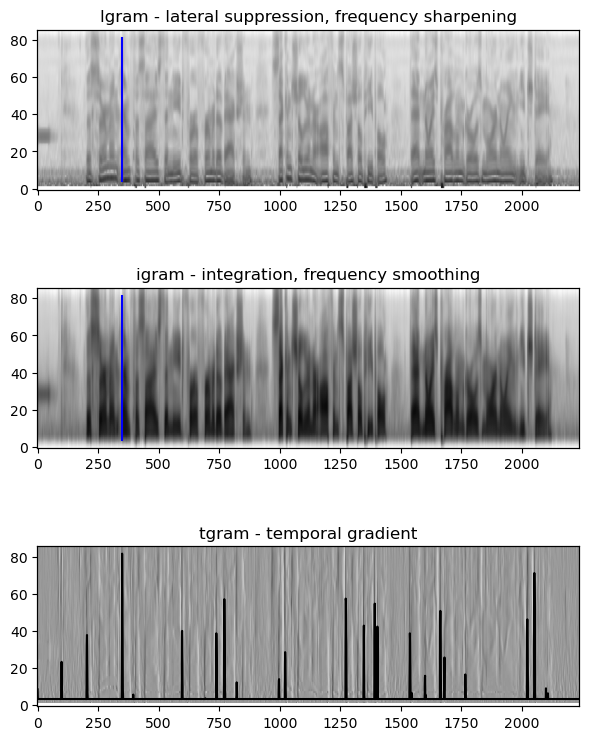

In [5]:
import matplotlib.pyplot as plt
import librosa

%matplotlib inline

import IPython.display as ipd

s = np.random.randint(len(wavdf))      # pick a random file for illustration
wavfile = wavdir / wavdf['relpath'][s] / wavdf['fname'][s]

data, _ = librosa.load(wavfile, sr=22050, mono=False)  # read data
if (data.shape[0]==2): data = data[0]                  # pick a channel if stereo

aud.make_zgram(data, rfftparams)   # critical band filtering

# derive three kinds of spectrogram
lgram = aud.apply_filt(aud.zgram, sharpen, axis=0, half_rectify=True)  # frequency sharpening
igram = aud.apply_filt(aud.zgram, blur, axis=0, half_rectify=True)  # frequency blurring
tgram = stats.zscore(np.gradient(aud.zgram,axis=0),axis=0)  # temporal change

# energy envelope  -- sum across spectrum
l_env = stats.zscore(np.nansum(lgram,axis=1))  # Zscore of sum energy across freq channels
t_env = stats.zscore(np.nansum(tgram,axis=1))

l_edges = np.gradient(l_env)  # gradient across channels in the lgram
t_env[t_env < 2] = 2   # limit to points that are > 2 sd above mean

lpeak = np.argmax(l_edges)
tpeak = np.argmax(t_env[2:-1])

# make the figure
fig, [ax1,ax2, ax3] = plt.subplots(3, 1)
ax1.imshow(lgram.T, origin='lower', aspect='auto', cmap = plt.cm.Greys)
ax2.imshow(igram.T, origin='lower', aspect='auto', cmap = plt.cm.Greys)
ax3.imshow(tgram.T, origin='lower', aspect='auto',cmap = plt.cm.Greys)
ax1.title.set_text('lgram - lateral suppression, frequency sharpening')
ax2.title.set_text('igram - integration, frequency smoothing')
ax3.title.set_text('tgram - temporal gradient')
ax1a = ax1.twinx()
ax1a.vlines(x = tpeak,ymin=0,ymax=1,color='r')
ax1a.vlines(x = lpeak,ymin=0,ymax=1,color='b')
ax1a.set_yticks([])
#ax1a.plot(l_env, 'k') 
ax2a = ax2.twinx()
ax2a.vlines(x = lpeak,ymin=0,ymax=1,color='b')
ax2a.set_yticks([])
ax3a = ax3.twinx()
#ax3a.vlines(x = tpeak,ymin=0,ymax=1,color='r')
ax3a.plot(t_env, 'k') 
ax3a.set_yticks([])
fig.tight_layout()
fig.set_size_inches(6, 8)

print("{}:".format(wavdf['fname'][s]))
print("peak gradient of igram envelope {}, peak in tgram envelope {}".format(lpeak,tpeak))

ipd.Audio(data,rate=22050)   # put up the audio control object

## Report how many new spec files will be created

The assumption here is that you don't want to over-write any 'audspec.npz' files that have already been created.

In [7]:
count = 0
for row in wavdf.itertuples():
    specname = specdir / row.relpath / f'{row.barename}.audspec.npz'
    
    if (os.path.isfile(specname)==False): 
        count=count+1
        
print(f'Out of {len(wavdf)} .wav files, {count} .audspec.npz files still need to be created.')

Out of 6549 .wav files, 0 .audspec.npz files still need to be created.


## Create and cache spectrograms

Create the auditory spectrograms and save in a `.npz` file. The `aud` object contains the acoustic and auditory spectrograms already, and you don't need to do anything special to save them when you call `savez()`. You can create other variables to be saved and pass them as additional parameters to `savez()`.

In [ ]:
count = 0
for row in wavdf.itertuples():
    # Create destination filename to be saved and create directory, if necessary.
    specname = specdir / row.relpath / f'{row.barename}.audspec.npz'
    
    if (os.path.isfile(specname)):   # if this audspec file was already created, you can skip it
        continue
    
    specname.resolve().parent.mkdir(parents=True, exist_ok=True)
    
    # Make the auditory spectrogram from .wav file.
    aud.make_zgram(
        wavdir / row.relpath / row.fname,
        rfftparams
    )

    # Apply image filters to the spectrogram.    
    lgram = aud.apply_filt(aud.zgram, sharpen, axis=0, half_rectify=True)  # frequency sharpening
    igram = aud.apply_filt(aud.zgram, blur, axis=0, half_rectify=True)  # frequency blurring
    tgram = stats.zscore(np.gradient(aud.zgram,axis=0),axis=0)  # temporal change


    # Save to disk, adding filtered auditory spectrograms.
    aud.savez(
        specname,
        igram=igram,   # Optional custom variables start from here.
        lgram=lgram,
        tgram=tgram
    )
    count=count+1
    
    if (count % 50 == 0):
        print(f'{count}. Saved {specname}')
    
    # Optional save to HDF5, adding filtered auditory spectrograms.
#    h5name = specdir / f'{row.barename}.audspec.h5'
#    aud.saveh5(
#        h5name,
#        igram=igram,   # Optional custom variables start from here.
#        lgram=lgram,
#        ogram=ogram,
#    )
#    print(f'Saved {h5name}.')